In [1]:
# ===============
# To look at where the skill comes from in classical decadal prediction hindcasts
# ===============

data_dir = '/data/mmenary/python_saves'
figure_dir = '/home/mmenary/python/notebooks/AnaloguePredictions_VersionControlled/output/'
scripts_dir = '/home/mmenary/python/scripts/'

import numpy as np
import glob
import pickle
import os
import matplotlib.pyplot as plt
from scipy import stats
import time
import matplotlib.gridspec as gridspec
from analogue import *
from matplotlib.lines import Line2D
import mfilter

%matplotlib inline

In [2]:
# ===============
# Hindcast models with the most members
# ===============
hind_models_most_members = ['MPI-ESM-LR', 'GEOS-5', 'MIROC5', 'NorCPM1', 'CanESM5', 'GFDL-CM2p1', 'MIROC6',
                            'CanCM4', 'IPSL-CM6A-LR', 'bcc-csm1-1']

# ===============
# Equivalent historical models
# ===============
hist_models_most_members = hind_models_most_members[:]
hist_models_most_members.remove('CanCM4')
hist_models_most_members += ['CanESM2']

print hind_models_most_members
print hist_models_most_members

# ===============
# Target (truth) variable
# ===============
var = 'SST'

# ===============
# Target (truth) region
# ===============
target_region = 'subpolar_gyre'
# target_region = 'north_atlantic'
# target_region = 'europe1'

['MPI-ESM-LR', 'GEOS-5', 'MIROC5', 'NorCPM1', 'CanESM5', 'GFDL-CM2p1', 'MIROC6', 'CanCM4', 'IPSL-CM6A-LR', 'bcc-csm1-1']
['MPI-ESM-LR', 'GEOS-5', 'MIROC5', 'NorCPM1', 'CanESM5', 'GFDL-CM2p1', 'MIROC6', 'IPSL-CM6A-LR', 'bcc-csm1-1', 'CanESM2']


In [3]:
# mpi_long_save = '/data/mmenary/python_saves/MPI_LongHinds_{:s}_TimeSeries.pkl'.format(var)
max_lead = 11
lead_times = np.arange(max_lead)  # Including a lead time of zero (i.e. the input correlation)

if var == 'SST':
    obs_save_file = '/data/mmenary/python_saves/HadISST_time_series_regions.pkl'
#     mpi = True
elif var == 'SAT':
    obs_save_file = '/data/mmenary/python_saves/HadCRUT4_time_series_regions.pkl'
#     mpi = True
elif var == 'DepthAverageT':
    obs_save_file = '/data/mmenary/python_saves/EN4_0-500m_time_series_regions.pkl'
#     mpi = False
else:
    raise ValueError('Unknown variable')
    
cmip5_list_file = os.path.join(scripts_dir, 'cmip5_list.txt')
cmip6_list_file = os.path.join(scripts_dir, 'cmip6_list.txt')

cmip5_models = []
with open(cmip5_list_file, 'r') as f:
    for line in f.readlines():
        cmip5_models.append(line.strip())

cmip6_models = []
with open(cmip6_list_file, 'r') as f:
    for line in f.readlines():
        cmip6_models.append(line.strip())

In [4]:
# =====================
# This is reading in some pre-processed hindcast/historical data, where I have
# already made the area averages and sanitised the data etc
# =====================
input_save_file = '{:s}/HistoricalAnalogues_Inputs_{:s}.pkl'.format(data_dir, var)
if os.path.isfile(input_save_file):
    with open(input_save_file, 'rb') as handle:
        print "Loading save file: {:s}".format(input_save_file)
        stored_data = pickle.load(handle)
        print " == Complete"
else:
    raise ValueError("This is created in a script now (AnalogueCache.py)")

Loading save file: /data/mmenary/python_saves/HistoricalAnalogues_Inputs_SST.pkl
 == Complete


In [5]:
# Read the real historical data for validation
with open(obs_save_file, 'rb') as handle:
    print "Loading save file: {:s}".format(obs_save_file)
    # Slightly different shape to the models (no spatial info)
    _, sst_ts_ann, _, year_ann = pickle.load(handle)
    nyrs = len(year_ann)
    
    # This should probably also be in a class, but I don't know how yet
    target_time_series = sst_ts_ann[target_region]
    print " == Complete"

Loading save file: /data/mmenary/python_saves/HadISST_time_series_regions.pkl
 == Complete


In [6]:
# =======================
# Functions to help processing the historical/hindcast data
# =======================
tol = 0.9

def anomalise3d(in_arr, t0, t1, tol=0.9):
    ni, nj, nt = in_arr.shape
    mn = in_arr[:, :, t0:t1].mean(axis=2)
    mn = np.repeat(mn[:, :, None], nt, axis=2)
    out = in_arr - mn
    for ii in range(ni):
        for jj in range(nj):
            if np.ma.count(in_arr[ii, jj, t0:t1]) < ((t1-t0) * tol):
                out[ii, jj, :].mask = True
    return out

# Inflated variance version:
def inflate3d(in_arr, target_std, t0, t1):
    _, _, nt = in_arr.shape
    mn3d = np.repeat(np.ma.mean(in_arr[:, :, t0:t1], axis=2)[:, :, None], nt, axis=2)
    in_arr_anom = anomalise3d(in_arr, t0, t1, tol=0.9)
    std3d = np.repeat(np.ma.std(in_arr[:, :, t0:t1], axis=2)[:, :, None], nt, axis=2)
    out = in_arr_anom * (target_std / std3d) + mn3d
    return out

Finding historical simulations in STORED_DATA
Computing historical averages
140330063556336 140330815104352
9


/home/mmenary/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in divide


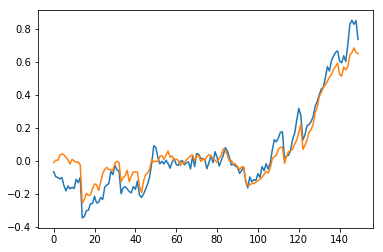

In [7]:
# =======================
# Historical simulations (not analogue approach)
# First have to get the data...
print "Finding historical simulations in STORED_DATA"
hist_models = []
for ii, record in enumerate(stored_data):
    if record.experiment == 'historical':
        hist_models.append(record.model)
hist_models = list(set(hist_models))
historical_time_series = np.ma.masked_all(shape=(len(hist_models), 10, len(year_ann)))

for irec, record in enumerate(stored_data):
    if not ((record.sub_var == target_region) and (record.var == var)):
        continue
    if not ((record.experiment == 'historical') or (record.experiment == 'rcp85') or (record.experiment == 'ssp585')):
        continue
    if record.model not in hist_models:
        # This could happen if it is future data
        continue
    
    imodel = hist_models.index(record.model)
    iens  = record.ens_mem - 1
    
    for tt_out, year in enumerate(year_ann):
        if year in record.time:
            tt_in = np.argwhere(record.time == year)[0][0]
            historical_time_series[imodel, iens, tt_out] = record.time_series[tt_in]

print "Computing historical averages"
t0 = np.argwhere(year_ann == 1900)[0][0]
t1 = np.argwhere(year_ann == 2000)[0][0]
historical_time_series_anom = anomalise3d(historical_time_series, t0, t1, tol=0.9)
historical_time_series_anom_ensmn = np.ma.mean(historical_time_series_anom, axis=1)
historical_time_series_anom_ensmn_mmm = np.ma.mean(historical_time_series_anom_ensmn, axis=0)

t0 = np.argwhere(year_ann == 1870)[0][0]
t1 = np.argwhere(year_ann == 2005)[0][0]

historical_time_series_anom_inf = inflate3d(historical_time_series_anom, target_time_series[t0:t1].std(), t0, t1)
historical_time_series_anom_inf_ensmn = np.ma.mean(historical_time_series_anom_inf, axis=1)
historical_time_series_anom_inf_ensmn_mmm = np.ma.mean(historical_time_series_anom_inf_ensmn, axis=0)

# Change this to the hind subset
histsub_models = ['IPSL-CM6A-LR', 'CNRM-CM5', 'MIROC5', 'CanESM2', 'FGOALS-g2', 'CanESM5', 'CMCC-CM', 'MIROC6', 'NorCPM1', 'EC-EARTH', 'MPI-ESM-MR', 'MRI-CGCM3', 'MPI-ESM-LR', 'bcc-csm1-1', 'GFDL-CM2p1']
histsub_models = hist_models_most_members[:]
print id(histsub_models), id(hist_models_most_members)

indhistsub = []
for imodel, model in enumerate(hist_models):
    if model in histsub_models:
        indhistsub.append(imodel)
print len(indhistsub)
        
historical_time_series_anom_ensmn_mmmsub = np.ma.mean(historical_time_series_anom_ensmn[indhistsub, :], axis=0)

plt.plot(historical_time_series_anom_ensmn_mmmsub)
plt.plot(historical_time_series_anom_ensmn_mmm)

In [8]:
# =======================
# Hindcast simulations (not analogue approach)
# First have to get the data...
print "Finding hindcast simulations in STORED_DATA"
hind_models = []
start_dates = []
hind_models_cm5, hind_models_cm6, start_dates_cm5, start_dates_cm6 = [], [], [], []
for ii, record in enumerate(stored_data):
    if record.experiment[:7] == 'decadal':
        if record.model not in hind_models_most_members:
            # MAJOR EDIT: Ignore models without many start dates
            continue
        hind_models.append(record.model)
        start_dates.append(np.long(record.experiment[7:]))
        if record.project == 'CMIP5':
            hind_models_cm5.append(record.model)
            start_dates_cm5.append(np.long(record.experiment[7:]))
        elif record.project == 'CMIP6':
            hind_models_cm6.append(record.model)
            start_dates_cm6.append(np.long(record.experiment[7:]))
        else:
            raise ValueError('Unknown project')
hind_models = list(set(hind_models))
hind_models_cm5 = list(set(hind_models_cm5))
hind_models_cm6 = list(set(hind_models_cm6))
nhind_models = len(hind_models)
start_dates = np.sort(np.array(list(set(start_dates))))
nstart_dates = start_dates.shape[0]

nens_mems = 10
n_hind_lead_times = 11  # We add 1 because 0 is lead=0 (which doesn't exist in hindcasts)

hindcast_time_series = np.ma.masked_all(shape=(nhind_models, nens_mems, len(year_ann), n_hind_lead_times))
hindcast_time_series_cm5 = np.ma.masked_all(shape=(nhind_models, nens_mems, len(year_ann), n_hind_lead_times))
hindcast_time_series_cm6 = np.ma.masked_all(shape=(nhind_models, nens_mems, len(year_ann), n_hind_lead_times))

unfull_models = []
for irec, record in enumerate(stored_data):
    if record.model not in hind_models_most_members:
        # MAJOR EDIT: Ignore models without many start dates
        continue
    if not ((record.experiment[:7] == 'decadal') and (record.sub_var == target_region) and (record.var == var)):
        continue
#     if record.model == 'IPSL-CM5A-LR': continue
        
#     if record.model == 'NorCPM1':  continue
        
#     if record.model == 'CanESM5':  continue  # Removed on Leo's advice due to errors in init in SPG
    
    imodel = hind_models.index(record.model)
    iens  = record.ens_mem - 1
    start_year = np.long(record.experiment[7:])
    istart_year = start_year - year_ann[0]
    
    # For each model/ens-mem, for the decadal init. year, put all the lead time data in
    for jj, year in enumerate(record.time):
        if (year - start_year) > 10: continue
        jj2 = year - start_year
        if jj2 == 0:
            unfull_models.append(record.model)
#             print "{:s}: This shouldn't exist, and if it does it's probably because there is an unfull annual mean".format(record.model)
            continue
        hindcast_time_series[imodel, iens, istart_year, jj2] = record.time_series[jj]
        if record.project == 'CMIP5':
            hindcast_time_series_cm5[imodel, iens, istart_year, jj2] = record.time_series[jj]
        elif record.project == 'CMIP6':
            hindcast_time_series_cm6[imodel, iens, istart_year, jj2] = record.time_series[jj]
print 'Unfull models: ', set(unfull_models)
    
hindcast_time_series_ensmn = np.ma.mean(hindcast_time_series, axis=1)
hindcast_time_series_ensmn_mmm = np.ma.mean(hindcast_time_series_ensmn, axis=0)

hindcast_time_series_ensmn_cm5 = np.ma.mean(hindcast_time_series_cm5, axis=1)
hindcast_time_series_ensmn_mmm5 = np.ma.mean(hindcast_time_series_ensmn_cm5, axis=0)
hindcast_time_series_ensmn_cm6 = np.ma.mean(hindcast_time_series_cm6, axis=1)
hindcast_time_series_ensmn_mmm6 = np.ma.mean(hindcast_time_series_ensmn_cm6, axis=0)

# def lead_time_bias_correction(hindcast_time_series_ensmn):
#     ndim = hindcast_time_series_ensmn.ndim
#     if ndim == 2:  # MMM
#         print 'Bias correcting MMM'
#         lead_time_bias = np.ma.mean(hindcast_time_series_ensmn, axis=0)
#         bias_corrected = hindcast_time_series_ensmn - lead_time_bias[None, :]  # Broadcast these together
#     elif ndim == 3:  # First dim is model
#         print 'Bias correcting all models'
#         lead_time_bias = np.ma.mean(hindcast_time_series_ensmn, axis=1)
#         bias_corrected = hindcast_time_series_ensmn - lead_time_bias[:, None, :]  # Broadcast these together
#     return bias_corrected

hindcast_time_series_ensmn_ltbc = lead_time_bias_correction(hindcast_time_series_ensmn)
hindcast_time_series_ensmn_ltbc_mmm = np.ma.mean(hindcast_time_series_ensmn_ltbc, axis=0)

hindcast_time_series_ensmn_ltbc_cm5 = lead_time_bias_correction(hindcast_time_series_ensmn_cm5)
hindcast_time_series_ensmn_ltbc_mmm5 = np.ma.mean(hindcast_time_series_ensmn_ltbc_cm5, axis=0)
hindcast_time_series_ensmn_ltbc_cm6 = lead_time_bias_correction(hindcast_time_series_ensmn_cm6)
hindcast_time_series_ensmn_ltbc_mmm6 = np.ma.mean(hindcast_time_series_ensmn_ltbc_cm6, axis=0)

print hindcast_time_series.shape
print hindcast_time_series_ensmn.shape
print hindcast_time_series_ensmn_mmm.shape

nmodels_with_this_start_date = nhind_models - np.ma.count_masked(hindcast_time_series_ensmn[:, :, 1], axis=0)


Finding hindcast simulations in STORED_DATA
Unfull models:  set(['GFDL-CM2p1', 'MIROC6', 'NorCPM1'])
Bias correcting all models
Bias correcting all models
Bias correcting all models
(10, 10, 150, 11)
(10, 150, 11)
(150, 11)


In [9]:
print start_dates

[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]


In [10]:
# ====================
# These are the models we will end up investigating
# ====================
print hind_models
print hind_models_cm5
print hind_models_cm6

['MPI-ESM-LR', 'GEOS-5', 'MIROC5', 'NorCPM1', 'CanESM5', 'GFDL-CM2p1', 'MIROC6', 'CanCM4', 'IPSL-CM6A-LR', 'bcc-csm1-1']
['GEOS-5', 'MIROC5', 'GFDL-CM2p1', 'CanCM4', 'MPI-ESM-LR', 'bcc-csm1-1']
['MIROC6', 'IPSL-CM6A-LR', 'NorCPM1', 'CanESM5']


In [11]:
# =======================
# Compute skill
# =======================
nlead = 11
# "start_lead" and "end_lead" are read as a pair, so the first "multiannual" skill is from years 1 to 5 (inclusive)
# and so on.
start_lead = [1, 2, 3, 4, 5, 6,  1,  2]
end_lead =   [5, 6, 7, 8, 9, 10, 10, 10]

print "Calculating skill of MMM hindcasts (LTBC)"
hindcast_time_series_ensmn_ltbc_mmm_corr = calculate_skill(hindcast_time_series_ensmn_ltbc_mmm, nlead, target_time_series, year_ann, tol=0.1)
hindcast_time_series_ensmn_ltbc_mmm_multicorr = calculate_skill(hindcast_time_series_ensmn_ltbc_mmm, nlead, target_time_series, year_ann, tol=0.1,
                                                                multi=True, start_lead=start_lead, end_lead=end_lead)


Calculating skill of MMM hindcasts (LTBC)


(10, 150, 11)


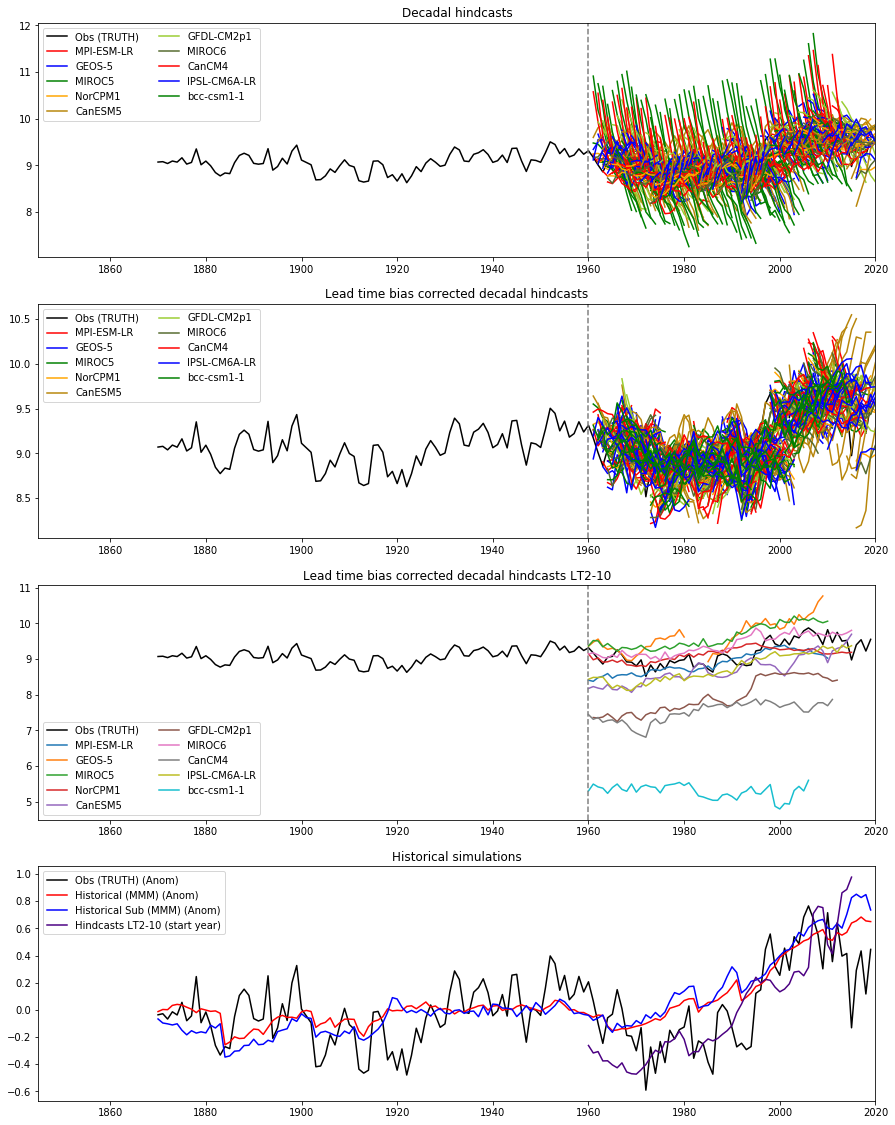

In [12]:
print hindcast_time_series_ensmn.shape

xlim = (1845, 2020)
colors  = ['red', 'blue', 'green', 'orange', 'darkgoldenrod', 'yellowgreen', 'darkolivegreen', 'grey']

plt.figure(figsize=(15, 25))
plt.subplot(5, 1, 1)
plt.plot(year_ann, target_time_series, color='k', label='Obs (TRUTH)')
for istart, year in enumerate(year_ann):
    for imodel, model in enumerate(hind_models):
        forecast = hindcast_time_series_ensmn[imodel, istart, :10]
        forecast_anom = forecast - np.ma.mean(forecast) + target_time_series[istart]
        if istart == 0:
            label = model
        else:
            label = None
        plt.plot(year+np.arange(10), forecast_anom, color=colors[imodel%7], label=label)
plt.xlim(xlim)
plt.axvline(1960, color='grey', linestyle='--')
plt.legend(ncol=2)
plt.title('Decadal hindcasts')

plt.subplot(5, 1, 2)
plt.plot(year_ann, target_time_series, color='k', label='Obs (TRUTH)')
for imodel, model in enumerate(hind_models):
    for istart, year in enumerate(year_ann):
        forecast = hindcast_time_series_ensmn_ltbc[imodel, istart, :10]
        forecast_anom = forecast - np.ma.mean(forecast) + target_time_series[istart]
        if istart == 0:
            label = model
        else:
            label = None
        plt.plot(year+np.arange(10), forecast_anom, color=colors[imodel%7], label=label)
plt.xlim(xlim)
plt.axvline(1960, color='grey', linestyle='--')
plt.legend(ncol=2)
plt.title('Lead time bias corrected decadal hindcasts')

plt.subplot(5, 1, 3)
plt.plot(year_ann, target_time_series, color='k', label='Obs (TRUTH)')
forecast = np.ma.mean(hindcast_time_series_ensmn_ltbc[:, :, 2:11], axis=2)
for imodel, model in enumerate(hind_models):
    plt.plot(year_ann, forecast[imodel, :], label=model)
plt.xlim(xlim)
plt.axvline(1960, color='grey', linestyle='--')
plt.legend(ncol=2)
plt.title('Lead time bias corrected decadal hindcasts LT2-10')

plt.subplot(5, 1, 4)
plt.plot(year_ann, target_time_series-np.ma.mean(target_time_series), color='k', label='Obs (TRUTH) (Anom)')
plt.plot(year_ann, historical_time_series_anom_ensmn_mmm, color='red', label='Historical (MMM) (Anom)')
plt.plot(year_ann, historical_time_series_anom_ensmn_mmmsub, color='blue', label='Historical Sub (MMM) (Anom)')

forecast_lt2t10 = np.ma.mean(hindcast_time_series_ensmn_ltbc_mmm[:, 2:11], axis=1)
plt.plot(year_ann, forecast_lt2t10-np.ma.mean(forecast_lt2t10), color='indigo', label='Hindcasts LT2-10 (start year)')

plt.xlim(xlim)
plt.legend()
plt.title('Historical simulations')

plt.show()

MPI-ESM-LR 51
GEOS-5 46
MIROC5 51
NorCPM1 56
CanESM5 56
GFDL-CM2p1 52
MIROC6 56
CanCM4 52
IPSL-CM6A-LR 56
bcc-csm1-1 47
['MPI-ESM-LR', 'GEOS-5', 'MIROC5', 'NorCPM1', 'CanESM5', 'GFDL-CM2p1', 'MIROC6', 'CanCM4', 'IPSL-CM6A-LR', 'bcc-csm1-1']
CMIP5 MPI-ESM-LR
CMIP5 GEOS-5
CMIP5 MIROC5
CMIP6 NorCPM1
CMIP6 CanESM5
CMIP5 GFDL-CM2p1
CMIP6 MIROC6
CMIP5 CanCM4
CMIP6 IPSL-CM6A-LR
CMIP5 bcc-csm1-1
(150, 11)
[0.856137130262183 0.8396262204220203 0.8354360328910098
 0.8225675258606808 0.8039353607160231 0.7774924232425819
 0.8760958727498613 0.8642124593820971]


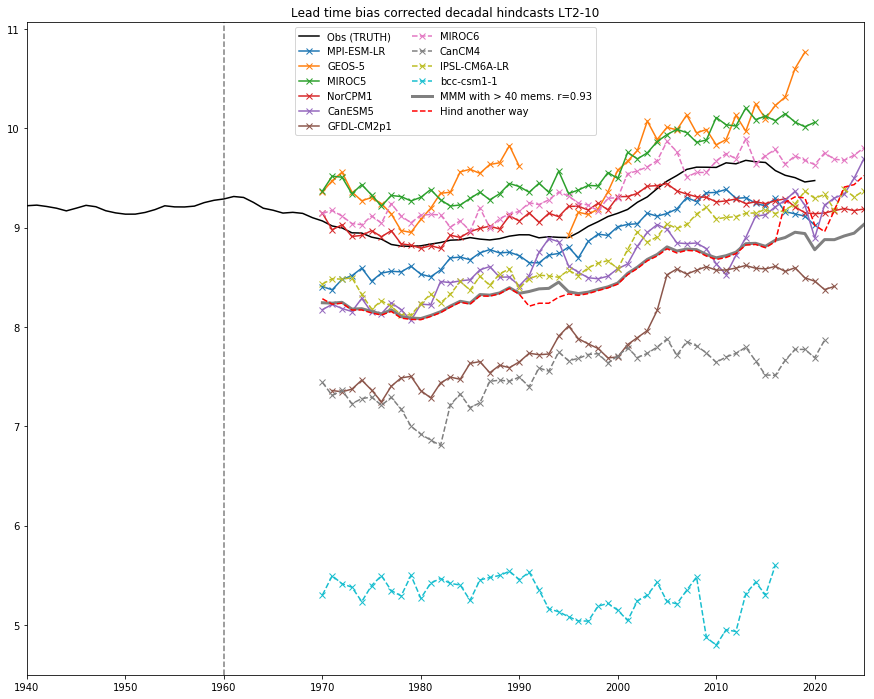

In [13]:
# =====================
# A closer look at the 3rd panel from above
# =====================
plt.figure(figsize=(15, 12))

target_time_series_lt2t10 = np.ma.masked_all(shape=target_time_series.shape)
for iyr in range(nyrs):
    if (iyr+10) > nyrs: continue
    target_time_series_lt2t10[iyr] = np.ma.mean(target_time_series[iyr:iyr+10])
plt.plot(year_ann+10, target_time_series_lt2t10, color='k', label='Obs (TRUTH)')
forecast = np.ma.mean(hindcast_time_series_ensmn_ltbc[:, :, 2:11], axis=2)
for imodel, model in enumerate(hind_models):
    ls = '-'
    if imodel >= 12:
        ls = '-.'
    elif imodel >= 6:
        ls = '--'
    color = None
    if model == 'MRI-CGCM3':
        color = 'k'
    plt.plot(year_ann+10, forecast[imodel, :], 'x', label=model, ls=ls, color=color)
#     plt.plot(year_ann+10, forecast[imodel, :], label=model, ls=ls, color=color)
plt.xlim(1940, 2025)
plt.axvline(1960, color='grey', linestyle='--')
plt.title('Lead time bias corrected decadal hindcasts LT2-10')

# Only choose models that have >min_count number of start dates
min_count = 40
forecast_anom = np.ma.masked_all(shape=forecast.shape)
forecast_mn = np.ma.masked_all(shape=forecast.shape[0])
retained_models = []
for imodel, model in enumerate(hind_models):
    count = forecast[imodel, :].count()
    print model, count
    if count > min_count:
        forecast_mn[imodel] = np.ma.mean(forecast[imodel, t0:t1])
        forecast_anom[imodel, :] = forecast[imodel, :] - forecast_mn[imodel]
        retained_models.append(model)
forecast_anom_mmm = np.ma.mean(forecast_anom, axis=0)
hindcast_time_series_ensmn_ltbc_mm40m_lt2t10 = forecast_anom_mmm + np.ma.mean(forecast_mn)

real = np.nonzero(hindcast_time_series_ensmn_ltbc_mm40m_lt2t10 * target_time_series_lt2t10)
corr = np.corrcoef(hindcast_time_series_ensmn_ltbc_mm40m_lt2t10[real], target_time_series_lt2t10[real])[0][1]

plt.plot(year_ann+10, hindcast_time_series_ensmn_ltbc_mm40m_lt2t10, color='grey', lw=3, label='MMM with > 40 mems. r={:.2f}'.format(corr))
print retained_models
for model in retained_models:
    if model in cmip5_models:
        project = 'CMIP5'
    elif model in cmip6_models:
        project = 'CMIP6'
    else:
        project = '?????'
    print project, model
    
print hindcast_time_series_ensmn_ltbc_mmm.shape
    
plt.plot(year_ann+10, np.ma.mean(hindcast_time_series_ensmn_ltbc_mmm[:, 2:11], axis=1), color='red',
         linestyle='--', label='Hind another way')
    
plt.legend(ncol=2)
print hindcast_time_series_ensmn_ltbc_mmm_multicorr

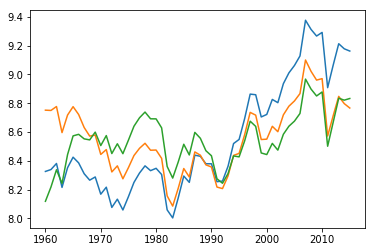

In [14]:
# ====================================
# Investigation into the hindcast skill. This shows it arises because the time series
# can be split into a low and high epoch, so the skill is basically just persistence
# within that epoch. Detrending (linearly) doesn't help much as the two epochs still exist
# ====================================

# This will detrend the hindcasts using the parallel obs (same validity time)
hindcast_time_series_ensmn_ltbc_mmm_detrended = np.ma.masked_all_like(hindcast_time_series_ensmn_ltbc_mmm)
hindcast_time_series_ensmn_ltbc_mmm_polydetrended = np.ma.masked_all_like(hindcast_time_series_ensmn_ltbc_mmm)

for jj, lead_time in enumerate(lead_times):
    target = target_time_series[jj:len(target_time_series)]
    these_years = year_ann[jj:len(target_time_series)]
    if jj !=0:
        # Normally, make sure truth and models are both valid
        estimate = hindcast_time_series_ensmn_ltbc_mmm[:len(hindcast_time_series_ensmn_ltbc_mmm)-jj, jj]
    else:
        #But if at lead=0 we are just making trends for the obs, so assume same as  lead=1 onwards
        estimate = hindcast_time_series_ensmn_ltbc_mmm[:len(hindcast_time_series_ensmn_ltbc_mmm)-jj, 1] 
    real = np.nonzero(target * estimate)[0]
    centre_year = np.ma.mean(these_years[real])
    
    # This will LINEAR detrend the hindcasts using the parallel obs (same validity time)
    grad, intercept, _, _, _ = stats.linregress(these_years[real], target[real])
    obs_trend_anom_linear = (year_ann - centre_year) * grad

    # This will POLY detrend the hindcasts using the parallel obs (same validity time)
    aa, bb, cc, dd = np.polyfit(these_years[real]-centre_year, target[real], 3)
    obs_trend_anom_poly = aa * (year_ann-centre_year)**3 + bb * (year_ann-centre_year)**2 + cc * (year_ann-centre_year) + dd
    obs_trend_anom_poly = obs_trend_anom_poly - np.ma.mean(obs_trend_anom_poly[real])
    
    if jj == 0:
        # For fair plotting forecasts against the detrended obs
        target_time_series_detrended = target_time_series - obs_trend_anom_linear
        target_time_series_polydetrended = target_time_series - obs_trend_anom_poly
        continue

    hindcast_time_series_ensmn_ltbc_mmm_detrended[:, jj] = hindcast_time_series_ensmn_ltbc_mmm[:, jj] - obs_trend_anom_linear
    hindcast_time_series_ensmn_ltbc_mmm_polydetrended[:, jj] = hindcast_time_series_ensmn_ltbc_mmm[:, jj] - obs_trend_anom_poly
    
plt.plot(year_ann, hindcast_time_series_ensmn_ltbc_mmm[:, 1])
plt.plot(year_ann, hindcast_time_series_ensmn_ltbc_mmm_detrended[:, 1])
plt.plot(year_ann, hindcast_time_series_ensmn_ltbc_mmm_polydetrended[:, 1])

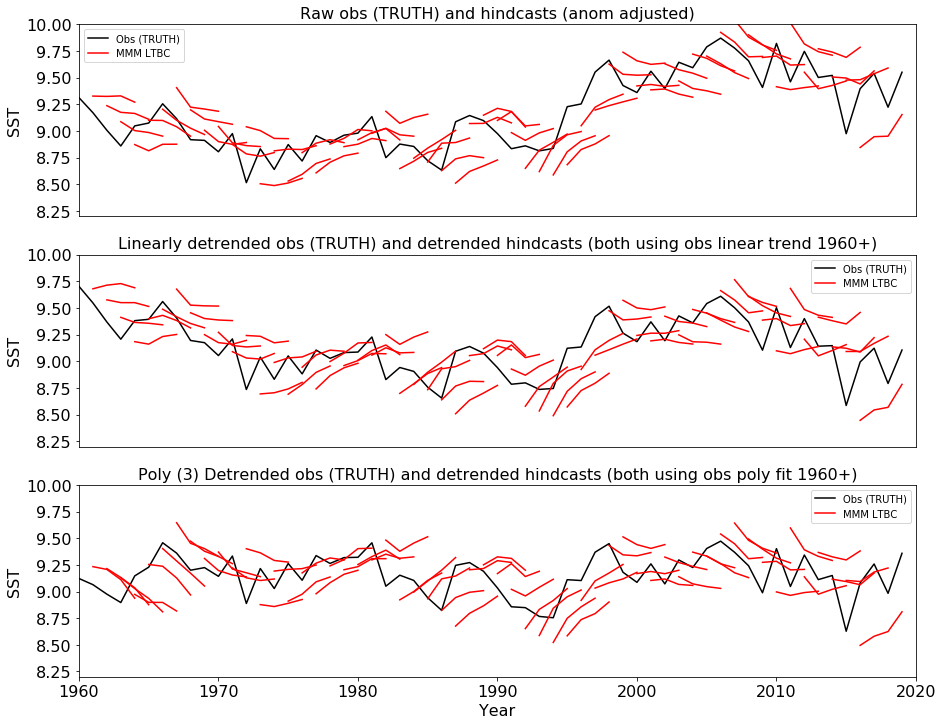

In [15]:
fontsize = 16
xlim = (1960, 2020)
ylim = (8.2, 10)

plt.figure(figsize=(15, 12))
plt.subplot(3, 1, 1)
plt.plot(year_ann, target_time_series, color='k', label='Obs (TRUTH)')
for istart, year in enumerate(year_ann):
    forecast = hindcast_time_series_ensmn_ltbc_mmm[istart, :5]
    forecast_anom = forecast - np.ma.mean(forecast) + target_time_series[istart]
    if istart == 0:
        label = 'MMM LTBC'
    else:
        label = None
    plt.plot(year+np.arange(5), forecast_anom, color='red', label=label)
    plt.xlim(xlim)
    plt.xticks([])
    plt.ylim(ylim)
    plt.ylabel(var, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend()
    plt.title('Raw obs (TRUTH) and hindcasts (anom adjusted)', fontsize=fontsize)
    
plt.subplot(3, 1, 2)
plt.plot(year_ann, target_time_series_detrended, color='k', label='Obs (TRUTH)')
for istart, year in enumerate(year_ann):
    forecast = hindcast_time_series_ensmn_ltbc_mmm_detrended[istart, :5]
    forecast_anom = forecast - np.ma.mean(forecast) + target_time_series_detrended[istart]
    if istart == 0:
        label = 'MMM LTBC'
    else:
        label = None
    plt.plot(year+np.arange(5), forecast_anom, color='red', label=label)
    plt.xlim(xlim)
    plt.xticks([])
    plt.ylim(ylim)
    plt.ylabel(var, fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend()
    plt.title('Linearly detrended obs (TRUTH) and detrended hindcasts (both using obs linear trend 1960+)', fontsize=fontsize)
    
plt.subplot(3, 1, 3)
plt.plot(year_ann, target_time_series_polydetrended, color='k', label='Obs (TRUTH)')
for istart, year in enumerate(year_ann):
    forecast = hindcast_time_series_ensmn_ltbc_mmm_polydetrended[istart, :5]
    forecast_anom = forecast - np.ma.mean(forecast) + target_time_series_polydetrended[istart]
    if istart == 0:
        label = 'MMM LTBC'
    else:
        label = None
    plt.plot(year+np.arange(5), forecast_anom, color='red', label=label)
    plt.xlim(xlim)
    plt.xticks(fontsize=fontsize)
    plt.xlabel('Year', fontsize=fontsize)
    plt.ylabel(var, fontsize=fontsize)
    plt.ylim(ylim)
    plt.yticks(fontsize=fontsize)
    plt.legend()
    plt.title('Poly (3) Detrended obs (TRUTH) and detrended hindcasts (both using obs poly fit 1960+)', fontsize=fontsize)

1 56
2 56
3 56
4 56
5 55
6 54
7 53
8 52
9 51
10 50
/home/mmenary/python/notebooks/AnaloguePredictions_VersionControlled/output/HistoricalAnalogues_HindcastBaseline_TARGETsubpolar_gyre_LTDS.png


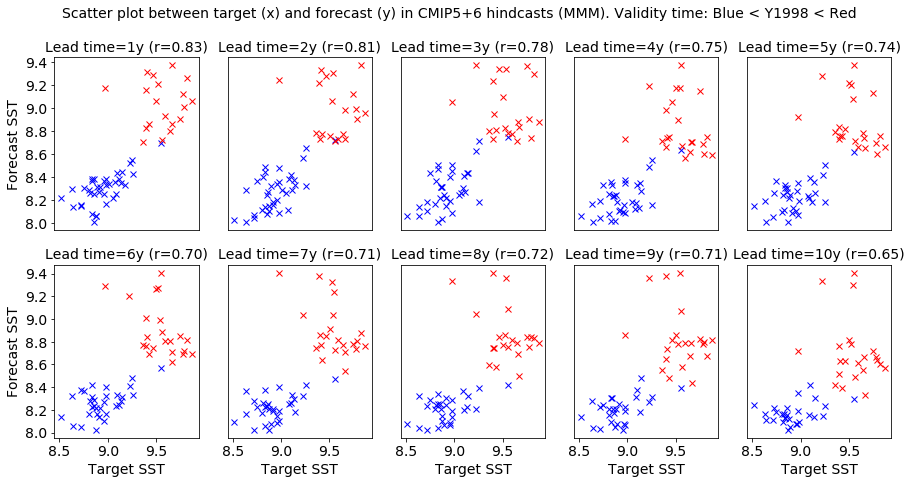

In [16]:
# ================
# No detrending (but LTDBC)
# ================

cutoff_year = 1998
ylim = (8, 10)
xlim = ylim
fontsize = 14
hindcast_time_series_ensmn_ltbc_mmm_corr = np.ma.masked_all(shape=len(lead_times))

plt.figure(figsize=(15, 7))
for jj, lead_time in enumerate(lead_times):
    if jj > 10: continue
    target = target_time_series[jj:len(target_time_series)]
    these_years = year_ann[jj:len(target_time_series)]
    estimate = hindcast_time_series_ensmn_ltbc_mmm[:len(hindcast_time_series_ensmn_ltbc_mmm)-jj, jj]
    real = np.nonzero(target * estimate)[0]
    if len(real) < 5: continue
    print lead_time, len(real)
    plt.subplot(2, 5, jj)
    for ii in range(len(real)):
        if these_years[real][ii] >= cutoff_year:
            color = 'red'
        else:
            color = 'blue'
        plt.plot(target[real][ii], estimate[real][ii], 'x', color=color)
    _, _, corr, _, _ = stats.linregress(target[real], estimate[real])
    plt.title('Lead time={:d}y (r={:.2f})'.format(lead_time, corr), fontsize=fontsize)
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()
#     plt.plot(xlim, xlim-xlim[0]+ylim[0], color='k')
    if (jj % 5) == 1:
        plt.ylabel('Forecast {:s}'.format(var), fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
    else:
        plt.yticks([])
    if jj > 5:
        plt.xlabel('Target {:s}'.format(var), fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
    else:
        plt.xticks([])
    hindcast_time_series_ensmn_ltbc_mmm_corr[jj] = corr
    
title = 'Scatter plot between target (x) and forecast (y) in CMIP5+6 hindcasts (MMM). Validity time: Blue < Y{:d} < Red'
plt.suptitle(title.format(cutoff_year), fontsize=fontsize)

fig_save_file = '{:s}HistoricalAnalogues_HindcastBaseline_TARGET{:s}_LTDS.png'.format(figure_dir, target_region)
print fig_save_file
plt.savefig(fig_save_file, bbox_inches = 'tight')

1 56
2 56
3 56
4 56
5 55
6 54
7 53
8 52
9 51
10 50
/home/mmenary/python/notebooks/AnaloguePredictions_VersionControlled/output/HistoricalAnalogues_DetrendedHindcastBaseline_TARGETsubpolar_gyre_LTDS.png


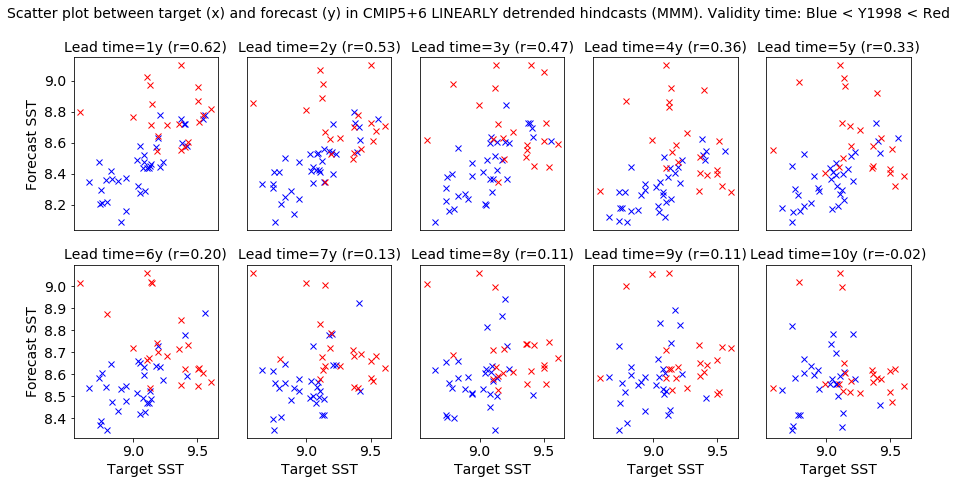

In [17]:
cutoff_year = 1998
ylim = (8, 10)
xlim = ylim
fontsize = 14
hindcast_time_series_ensmn_ltbc_mmm_detrended_corr = np.ma.masked_all(shape=len(lead_times))

plt.figure(figsize=(15, 7))
for jj, lead_time in enumerate(lead_times):
    if jj > 10: continue
    target = target_time_series_detrended[jj:len(target_time_series_detrended)]
    these_years = year_ann[jj:len(target_time_series_detrended)]
    estimate = hindcast_time_series_ensmn_ltbc_mmm_detrended[:len(hindcast_time_series_ensmn_ltbc_mmm_detrended)-jj, jj]
    real = np.nonzero(target * estimate)[0]
    if len(real) < 5: continue
    print lead_time, len(real)
    plt.subplot(2, 5, jj)
    for ii in range(len(real)):
        if these_years[real][ii] >= cutoff_year:
            color = 'red'
        else:
            color = 'blue'
        plt.plot(target[real][ii], estimate[real][ii], 'x', color=color)
    _, _, corr, _, _ = stats.linregress(target[real], estimate[real])
    plt.title('Lead time={:d}y (r={:.2f})'.format(lead_time, corr), fontsize=fontsize)
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()
#     plt.plot(xlim, xlim-xlim[0]+ylim[0], color='k')
    if (jj % 5) == 1:
        plt.ylabel('Forecast {:s}'.format(var), fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
    else:
        plt.yticks([])
    if jj > 5:
        plt.xlabel('Target {:s}'.format(var), fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
    else:
        plt.xticks([])
    hindcast_time_series_ensmn_ltbc_mmm_detrended_corr[jj] = corr
    
title = 'Scatter plot between target (x) and forecast (y) in CMIP5+6 LINEARLY detrended hindcasts (MMM). Validity time: Blue < Y{:d} < Red'
plt.suptitle(title.format(cutoff_year), fontsize=fontsize)

fig_save_file = '{:s}HistoricalAnalogues_DetrendedHindcastBaseline_TARGET{:s}_LTDS.png'.format(figure_dir, target_region)
print fig_save_file
plt.savefig(fig_save_file, bbox_inches = 'tight')

1 56
2 56
3 56
4 56
5 55
6 54
7 53
8 52
9 51
10 50
/home/mmenary/python/notebooks/AnaloguePredictions_VersionControlled/output/HistoricalAnalogues_PolyHindcastBaseline_TARGETsubpolar_gyre_LTDS.png


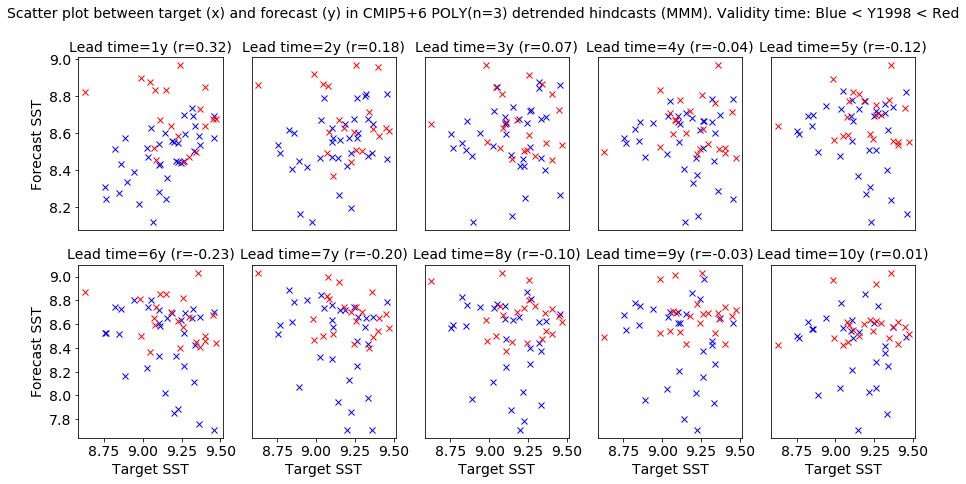

In [18]:
cutoff_year = 1998
ylim = (8, 10)
xlim = ylim
fontsize = 14
hindcast_time_series_ensmn_ltbc_mmm_polydetrended_corr = np.ma.masked_all(shape=len(lead_times))

plt.figure(figsize=(15, 7))
for jj, lead_time in enumerate(lead_times):
    if jj > 10: continue
    target = target_time_series_polydetrended[jj:len(target_time_series_polydetrended)]
    these_years = year_ann[jj:len(target_time_series_polydetrended)]
    estimate = hindcast_time_series_ensmn_ltbc_mmm_polydetrended[:len(hindcast_time_series_ensmn_ltbc_mmm_polydetrended)-jj, jj]
    real = np.nonzero(target * estimate)[0]
    if len(real) < 5: continue
    print lead_time, len(real)
    plt.subplot(2, 5, jj)
    for ii in range(len(real)):
        if these_years[real][ii] >= cutoff_year:
            color = 'red'
        else:
            color = 'blue'
        plt.plot(target[real][ii], estimate[real][ii], 'x', color=color)
    _, _, corr, _, _ = stats.linregress(target[real], estimate[real])
    plt.title('Lead time={:d}y (r={:.2f})'.format(lead_time, corr), fontsize=fontsize)
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()
#     plt.plot(xlim, xlim-xlim[0]+ylim[0], color='k')
    if (jj % 5) == 1:
        plt.ylabel('Forecast {:s}'.format(var), fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
    else:
        plt.yticks([])
    if jj > 5:
        plt.xlabel('Target {:s}'.format(var), fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
    else:
        plt.xticks([])
    hindcast_time_series_ensmn_ltbc_mmm_polydetrended_corr[jj] = corr
    
title = 'Scatter plot between target (x) and forecast (y) in CMIP5+6 POLY(n=3) detrended hindcasts (MMM). Validity time: Blue < Y{:d} < Red'
plt.suptitle(title.format(cutoff_year), fontsize=fontsize)

fig_save_file = '{:s}HistoricalAnalogues_PolyHindcastBaseline_TARGET{:s}_LTDS.png'.format(figure_dir, target_region)
print fig_save_file
plt.savefig(fig_save_file, bbox_inches = 'tight')

1.2671345454388454e-15
5.921189464667502e-18
0.8130121933199508 1.262320546205113e-15 0.012793711812498451


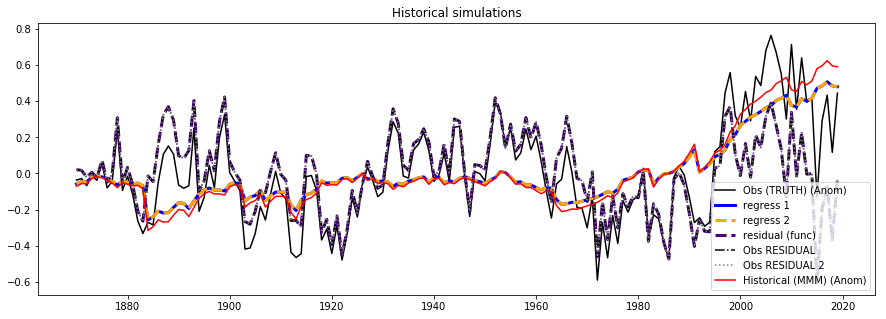

In [19]:
target_time_series_anom = target_time_series-np.ma.mean(target_time_series)
historical_time_series_anom_ensmn_mmm_anom = historical_time_series_anom_ensmn_mmm-np.ma.mean(historical_time_series_anom_ensmn_mmm)

real = np.nonzero(target_time_series_anom * historical_time_series_anom_ensmn_mmm_anom)
grad, inte, corr_obs_hist, _, _ = stats.linregress(historical_time_series_anom_ensmn_mmm_anom[real],
                                          target_time_series_anom[real])
regress1 = historical_time_series_anom_ensmn_mmm_anom*grad+inte

sd_obs = np.ma.std(target_time_series_anom[real])
sd_hist = np.ma.std(historical_time_series_anom_ensmn_mmm_anom[real])
regress2 = corr_obs_hist * (sd_obs / sd_hist) * historical_time_series_anom_ensmn_mmm_anom

residual = calculate_residual(target_time_series_anom, 1, historical_time_series_anom_ensmn_mmm_anom)

target_time_series_res2 = target_time_series_anom - regress1

target_time_series_res = calculate_residual(target_time_series, 1, historical_time_series_anom_ensmn_mmm_anom)

forecast = np.ma.masked_all(shape=(nyrs, nlead))
for ilead in range(nlead):
    forecast[:, ilead] = target_time_series_res[:]
persistence_res_corr = calculate_skill(forecast, nlead, target_time_series_res, year_ann)
persistence_res_multicorr = calculate_skill(forecast, nlead, target_time_series_res, year_ann, multi=True,
                                            start_lead=start_lead, end_lead=end_lead)

plt.figure(figsize=(15, 5))
plt.plot(year_ann, target_time_series_anom, color='k', label='Obs (TRUTH) (Anom)')
plt.plot(year_ann, regress1, color='blue', linestyle='-', label='regress 1', lw=3)
plt.plot(year_ann, regress2, color='orange', linestyle='--', label='regress 2', lw=3)
plt.plot(year_ann, residual, color='indigo', linestyle='--', label='residual (func)', lw=3)
plt.plot(year_ann, target_time_series_res, color='k', linestyle='-.', label='Obs RESIDUAL')
plt.plot(year_ann, target_time_series_res2, color='grey', linestyle=':', label='Obs RESIDUAL 2')
plt.plot(year_ann, historical_time_series_anom_ensmn_mmm_anom, color='red', label='Historical (MMM) (Anom)')
plt.legend()
plt.title('Historical simulations')

print target_time_series_anom.mean()
print historical_time_series_anom_ensmn_mmm_anom.mean()
print grad, inte, corr

Calculating skill of MMM hindcasts (LTBC) with forced component removed
(150, 11)
(150, 11)
Bias correcting MMM
Bias correcting MMM
/home/mmenary/python/notebooks/AnaloguePredictions_VersionControlled/output/HistoricalAnalogues_InvestigateHindcastSkill_TARGETsubpolar_gyre_Residuals.png


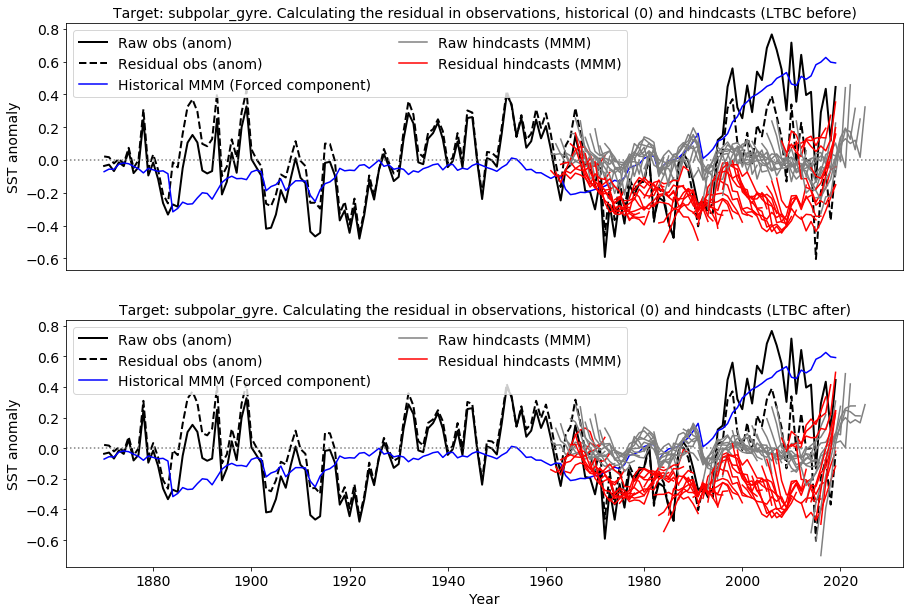

In [20]:
print "Calculating skill of MMM hindcasts (LTBC) with forced component removed"
print hindcast_time_series_ensmn_ltbc_mmm.shape
    
hindcast_time_series_ensmn_ltbc_mmm_res = calculate_residual(hindcast_time_series_ensmn_ltbc_mmm, nlead, historical_time_series_anom_ensmn_mmm_anom)    
hindcast_time_series_ensmn_mmm_res = calculate_residual(hindcast_time_series_ensmn_mmm, nlead, historical_time_series_anom_ensmn_mmm_anom)

# Note that the TARGET has to be different here:
hindcast_time_series_ensmn_mmm_res_corr = calculate_skill(hindcast_time_series_ensmn_mmm_res, nlead, target_time_series_res, year_ann,
                                                          tol=0.1)
hindcast_time_series_ensmn_mmm_res_multicorr = calculate_skill(hindcast_time_series_ensmn_mmm_res, nlead, target_time_series_res, year_ann,
                                                               tol=0.1,multi=True,
                                                               start_lead=start_lead, end_lead=end_lead)

hindcast_time_series_ensmn_ltbc_mmm_res_corr = calculate_skill(hindcast_time_series_ensmn_ltbc_mmm_res, nlead, target_time_series_res, year_ann,
                                                               tol=0.1)
hindcast_time_series_ensmn_ltbc_mmm_res_multicorr = calculate_skill(hindcast_time_series_ensmn_ltbc_mmm_res, nlead, target_time_series_res, year_ann,
                                                                    tol=0.1,multi=True,
                                                                    start_lead=start_lead, end_lead=end_lead)

print hindcast_time_series_ensmn_mmm.shape
hindcast_time_series_ensmn_mmm_ltbc = lead_time_bias_correction(hindcast_time_series_ensmn_mmm)
hindcast_time_series_ensmn_mmm_res_ltbc = lead_time_bias_correction(hindcast_time_series_ensmn_mmm_res)

hindcast_time_series_ensmn_mmm_res_ltbc_corr = calculate_skill(hindcast_time_series_ensmn_mmm_res_ltbc, nlead, target_time_series_res, year_ann,
                                                               tol=0.1)
hindcast_time_series_ensmn_mmm_res_ltbc_multicorr = calculate_skill(hindcast_time_series_ensmn_mmm_res_ltbc, nlead, target_time_series_res, year_ann,
                                                                    tol=0.1,multi=True,
                                                                    start_lead=start_lead, end_lead=end_lead)

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(year_ann, target_time_series-target_time_series.mean(), color='k', lw=2, label='Raw obs (anom)')
plt.plot(year_ann, target_time_series_res, color='k', linestyle='--', lw=2, label='Residual obs (anom)')
plt.plot(year_ann, historical_time_series_anom_ensmn_mmm_anom, color='blue',
         label='Historical MMM (Forced component)')
for ii in range(nyrs):
    if ii == 0:
        label = 'Raw hindcasts (MMM)'
        label_res = 'Residual hindcasts (MMM)'
    else:
        label = label_res = None
    plt.plot(year_ann[ii]+np.arange(max_lead), hindcast_time_series_ensmn_ltbc_mmm[ii, :]-hindcast_time_series_ensmn_ltbc_mmm[ii, :].mean(),
             color='grey', label=label)
    plt.plot(year_ann[ii]+np.arange(max_lead), hindcast_time_series_ensmn_ltbc_mmm_res[ii, :],
             color='red', label=label_res)
plt.axhline(0, linestyle=':', color='grey')
# plt.xlabel('Year', fontsize=fontsize)
plt.ylabel('{:s} anomaly'.format(var), fontsize=fontsize)
plt.title('Target: {:s}. Calculating the residual in observations, historical (0) and hindcasts (LTBC before)'.format(target_region), fontsize=fontsize)
plt.xticks([], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(loc=0, ncol=2, fontsize=fontsize)

plt.subplot(2, 1, 2)
plt.plot(year_ann, target_time_series-target_time_series.mean(), color='k', lw=2, label='Raw obs (anom)')
plt.plot(year_ann, target_time_series_res, color='k', linestyle='--', lw=2, label='Residual obs (anom)')
plt.plot(year_ann, historical_time_series_anom_ensmn_mmm_anom, color='blue',
         label='Historical MMM (Forced component)')
for ii in range(nyrs):
    if ii == 0:
        label = 'Raw hindcasts (MMM)'
        label_res = 'Residual hindcasts (MMM)'
    else:
        label = label_res = None
    plt.plot(year_ann[ii]+np.arange(max_lead), hindcast_time_series_ensmn_mmm_ltbc[ii, :]-hindcast_time_series_ensmn_ltbc_mmm[ii, :].mean(),
             color='grey', label=label)
    plt.plot(year_ann[ii]+np.arange(max_lead), hindcast_time_series_ensmn_mmm_res_ltbc[ii, :],
             color='red', label=label_res)
plt.axhline(0, linestyle=':', color='grey')
plt.xlabel('Year', fontsize=fontsize)
plt.ylabel('{:s} anomaly'.format(var), fontsize=fontsize)
plt.title('Target: {:s}. Calculating the residual in observations, historical (0) and hindcasts (LTBC after)'.format(target_region), fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(loc=0, ncol=2, fontsize=fontsize)

fig_save_file = '{:s}HistoricalAnalogues_InvestigateHindcastSkill_TARGET{:s}_Residuals.png'
fig_save_file = fig_save_file.format(figure_dir, target_region)
print fig_save_file
plt.savefig(fig_save_file, bbox_inches = 'tight')